In [319]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [320]:
import numpy as np
import pandas as pd

In [321]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [322]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import and_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [323]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [324]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [325]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [326]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [327]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [328]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

In [329]:
# Get a list of column names and types for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [330]:
# Get a list of column names and types for measurment table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [331]:
# Latest Date on record in string format
last_measurement_date = session.query(Measurement.date).\
                           order_by(Measurement.date.desc()).first()[0]
last_measurement_date

'2017-08-23'

In [332]:
# Break down the latest date into interget year, month and day components
last_measurement_year = int(last_measurement_date[0:4])
last_measurement_month = int(last_measurement_date[5:7])
last_measurement_day = int(last_measurement_date[8:11])

In [333]:
# Get the date 12 months ago from the lasest date on record
last_year = dt.date(last_measurement_year, last_measurement_month, last_measurement_day) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [334]:
#for row in session.query(Measurement.date, Measurement.prcp).limit(15).all():
#   print(row)

In [335]:
#for row in session.query(Measurement.date, Measurement.prcp).all():
   # print(row)

In [336]:
# Retrieve the last 12 months of precipitation data.
last_12_months_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    filter(and_(Measurement.date) <= last_measurement_date)
last_12_months_prcp

for row in last_12_months_prcp:
   print(row)

('2016-08-23', 0.0)
('2016-08-24', 0.08)
('2016-08-25', 0.08)
('2016-08-26', 0.0)
('2016-08-27', 0.0)
('2016-08-28', 0.01)
('2016-08-29', 0.0)
('2016-08-30', 0.0)
('2016-08-31', 0.13)
('2016-09-01', 0.0)
('2016-09-02', 0.0)
('2016-09-03', 0.0)
('2016-09-04', 0.03)
('2016-09-05', None)
('2016-09-06', None)
('2016-09-07', 0.05)
('2016-09-08', 0.0)
('2016-09-09', 0.03)
('2016-09-10', 0.0)
('2016-09-11', 0.05)
('2016-09-12', 0.0)
('2016-09-13', 0.02)
('2016-09-14', 1.32)
('2016-09-15', 0.42)
('2016-09-16', 0.06)
('2016-09-17', 0.05)
('2016-09-18', 0.0)
('2016-09-19', 0.0)
('2016-09-20', 0.0)
('2016-09-21', 0.0)
('2016-09-22', 0.02)
('2016-09-23', 0.0)
('2016-09-24', 0.0)
('2016-09-25', 0.0)
('2016-09-26', 0.06)
('2016-09-27', 0.02)
('2016-09-28', 0.0)
('2016-09-29', 0.0)
('2016-09-30', 0.0)
('2016-10-01', 0.0)
('2016-10-02', 0.0)
('2016-10-03', 0.0)
('2016-10-04', 0.0)
('2016-10-05', 0.0)
('2016-10-06', 0.0)
('2016-10-07', 0.0)
('2016-10-08', 0.0)
('2016-10-09', 0.0)
('2016-10-10', 0.0)
('

('2016-10-23', 0.02)
('2016-10-24', 0.08)
('2016-10-25', 0.11)
('2016-10-26', 0.01)
('2016-10-27', 0.22)
('2016-10-28', 0.05)
('2016-10-29', 0.1)
('2016-10-30', 0.16)
('2016-10-31', 0.07)
('2016-11-01', 0.1)
('2016-11-02', 0.0)
('2016-11-03', 0.0)
('2016-11-04', 0.0)
('2016-11-05', 0.03)
('2016-11-06', 0.01)
('2016-11-07', 0.0)
('2016-11-08', 0.21)
('2016-11-09', 0.11)
('2016-11-10', 0.0)
('2016-11-11', 0.0)
('2016-11-12', 0.0)
('2016-11-13', 0.0)
('2016-11-14', 0.0)
('2016-11-15', 0.0)
('2016-11-16', 0.24)
('2016-11-17', 0.01)
('2016-11-18', 0.0)
('2016-11-19', 0.11)
('2016-11-20', 0.39)
('2016-11-21', 0.11)
('2016-11-22', 2.05)
('2016-11-23', 0.25)
('2016-11-24', 0.3)
('2016-11-25', 0.08)
('2016-11-26', 0.06)
('2016-11-27', 0.17)
('2016-11-28', 0.0)
('2016-11-29', 0.09)
('2016-11-30', 0.05)
('2016-12-01', 0.37)
('2016-12-02', 0.35)
('2016-12-03', 0.77)
('2016-12-04', 0.04)
('2016-12-05', 0.22)
('2016-12-06', 0.0)
('2016-12-07', 0.12)
('2016-12-08', 0.07)
('2016-12-09', 0.31)
('2016-1

In [337]:
# Get a list of column names and types for measurment table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [338]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_12_months_prcp[:], columns = ["date", "prcp"]).dropna()
prcp_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [339]:
# Sort the DataFrame values by `date`
prcp_df.set_index('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


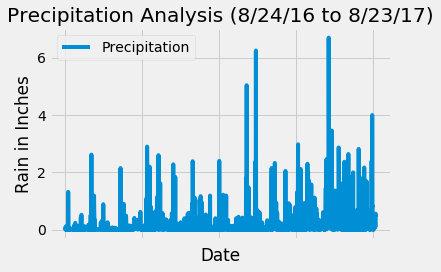

In [340]:
prcp_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [341]:
str(last_year)
title_txt = "Precipitation Analysis " + str(last_year) + " throu " + str(last_measurement_date)
title_txt

'Precipitation Analysis 2016-08-23 throu 2017-08-23'

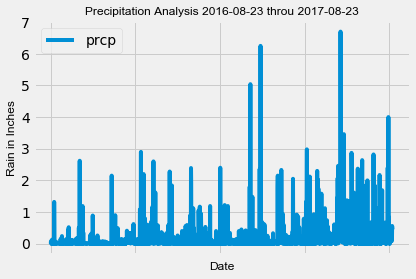

In [381]:
# Plot the results
prcp_df.plot("date", "prcp")
plt.xlabel("Date", fontname='Arial', fontsize=12)
plt.ylabel("Rain in Inches", fontname='Arial', fontsize=12)
title_txt = "Precipitation Analysis " + str(last_year) + " throu " + str(last_measurement_date)
plt.title(title_txt, fontname='Arial', fontsize=12)
#plt.legend(scatterpoints=1, loc="best", title="Precipitation")
#plt.legend(["Precipitation"])
#plt.ylim(20,20)
#plt.xlim(-0.25, len(x_axis))
#plt.ylim(0, max(prcp_df["date"])+10)
#plt.xlim(0, 10)
#plt.xticks(rotation=45)

#plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [181]:
# Use Pandas to calcualte the summary statistics for the precipitation data


In [182]:
# How many stations are available in this dataset?


In [183]:
# What are the most active stations?
# List the stations and the counts in descending order.


In [184]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [185]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [186]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [187]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [188]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [189]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [190]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [191]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [192]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [193]:
# Plot the daily normals as an area plot with `stacked=False`
